In [1]:
import pandas as pd
import time
import seaborn
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import linear_model
import kernelml
import re

from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]

dview.block = True

with dview.sync_imports():
    #for some reason, aliases cannot be use
    import numpy
    import scipy

importing numpy on engine(s)
importing scipy on engine(s)


In [30]:
full = pd.read_csv('DATA/hb_training.csv')
test = pd.read_csv('DATA/hb_testing.csv')

def change_label(x):
    if x =='s':
        return 1
    else: 
        return 0
    
full['Label'] = full['Label'].apply(change_label)
EventId = test['EventId']
full.drop(['EventId'],axis=1,inplace=True)
test.drop(['EventId'],axis=1,inplace=True)
features = list(full.columns[:-2])
target = list(full.columns[-1:])

#randomly sample and split data
all_samples=full.index
ones = full[full[target].values==1].index
zeros = full[full[target].values==0].index
ones_rand_sample = np.random.choice(ones, size=int(len(ones)*0.5),replace=False)
zeros_rand_sample = np.random.choice(zeros, size=int(len(zeros)*0.5),replace=False)
rand_sample  = np.concatenate((ones_rand_sample,zeros_rand_sample))
np.random.shuffle(rand_sample)

test_sample = np.setdiff1d(all_samples,rand_sample)
valid = full.loc[test_sample,:]
train = full.loc[rand_sample,:]

In [31]:
num_inputs = len(features)
num_outputs = len(features)
layer_sizes = [10]
model_shapes = []

model_shapes.append((num_inputs,layer_sizes[0]))
input_n_parameters = num_inputs*layer_sizes[0]
N =  input_n_parameters

for i in range(1,len(layer_sizes)):
    layer_n_parameters = layer_sizes[i-1]*layer_sizes[i]
    model_shapes.append((layer_sizes[i],layer_sizes[i-1]))
    N += layer_n_parameters

output_n_parameters = num_outputs*layer_sizes[-1]
N += output_n_parameters
model_shapes.append((num_outputs,layer_sizes[-1]))
num_parameters = N
N,model_shapes

(600, [(30, 10), (30, 10)])

In [32]:
# shapehelper = NNShapeHelper([10,len(features)],len(features),1)
# num_parameters = shapehelper.get_N_parameters()
# shapes = [shapehelper.model_shape,shapehelper.parameter_shape]
# shapes,num_parameters

In [33]:
#reshape parameter vector into list of matrices
def reshape_vector(w):
    reshape_w = []
    indx = 0
    for shape,num in zip(model_shape,parameter_shape):
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape,int(num/shape))
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:]
    return reshape_w,extra_w

def reshape_vector(w):
    np=numpy
    reshape_w = []
    indx = 0
    for shape in model_shapes:
        num = np.prod(shape)
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape)
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:].reshape(-1,1)
    return np.array(reshape_w),extra_w

#Specifies the way the tensors are combined with the inputs
def combine_tensors(X,w_tensor):
    w_tensor,extra_w = reshape_vector(w_tensor)
    b1,a1,b2,a2 = extra_w[:4]
    pred = X.dot(w_tensor[0])
    #choose link on encoding layer
    pred = a1*(pred+b1)
    pred = pred.dot(w_tensor[1].T)
    pred = a2*(pred+b2)
    return pred

In [37]:
dview['model_shapes']=model_shapes
dview['combine_tensors']=combine_tensors
dview['reshape_vector']=reshape_vector

In [38]:
def autoencoder_function(X,y,w_tensor,predict=False):
    #can't be passed to parallel engines, so I just assign the aliases manually
    #this is an improvement from loading the libraries again
    np = numpy
    stats = scipy.stats
    
    # define the loss function between predicted output actual output
    def nn_autoencoder_loss(hypothesis,y):
        return np.sum((hypothesis-y)**2)/y.size
    
    #we cannot modify pickled memory so create a copy of the parameter vector
    w_tensor_copy = w_tensor.copy()
    pred = combine_tensors(X,w_tensor_copy)
    if predict==True:
        return pred
    loss = nn_autoencoder_loss(pred,y)
    return loss

In [40]:
X = train[features].values
y = train[target].values


#parameter transform
def constraint_transform(w):
    w[np.where(np.abs(w)>5)] = 5*w[np.where(np.abs(w)>5)]/np.abs(w[np.where(np.abs(w)>5)]) 
    return w

realizations = 20
cycles = 5
volume = 40
simulations = 3000
volatility = 0.01

batch_size=500

zscore = 2.0

import time
start = time.time()

kml = kernelml.KernelML(
         prior_sampler_fcn=None,
         posterior_sampler_fcn=None,
         intermediate_sampler_fcn=None,
         mini_batch_sampler_fcn=None,
         parameter_transform_fcn=None,
         batch_size=batch_size)

kml.use_ipyparallel(dview)

parameter_by_run,loss_by_run = kml.optimize(X,X,loss_function=autoencoder_function,
                                number_of_parameters=num_parameters+4,
                                args=[],
                                number_of_realizations=realizations,
                                number_of_random_simulations=simulations,
                                update_volatility = volatility,
                                number_of_cycles=cycles,
                                update_volume=volume,
                                prior_uniform_low=-1,
                                prior_uniform_high=1,
                                convergence_z_score=zscore,
                                plot_feedback=False,
                                print_feedback=True)
end = time.time()

print(end-start)

('realization', 0, 'loss', 76107.195938158591, 'time', 5.942706823348999)
('realization', 1, 'loss', 48840.295057050898, 'time', 6.122480869293213)
('realization', 2, 'loss', 33327.403997283873, 'time', 6.742632865905762)
('realization', 3, 'loss', 27329.353391080396, 'time', 6.610260009765625)
('realization', 4, 'loss', 19622.446254575385, 'time', 6.733449935913086)
('realization', 5, 'loss', 15045.266365762734, 'time', 6.165683031082153)
('realization', 6, 'loss', 12421.891320053855, 'time', 6.550469875335693)
('realization', 7, 'loss', 11088.197148225698, 'time', 6.800249814987183)
('realization', 8, 'loss', 8981.2265498882734, 'time', 6.639477014541626)
('realization', 9, 'loss', 7253.0849197167227, 'time', 6.585238933563232)
('realization', 10, 'loss', 6438.8320106083584, 'time', 6.757697105407715)
('realization', 11, 'loss', 5867.0427249286258, 'time', 7.00865912437439)
('realization', 12, 'loss', 5390.2583248174869, 'time', 8.055474042892456)
('realization', 13, 'loss', 4788.615

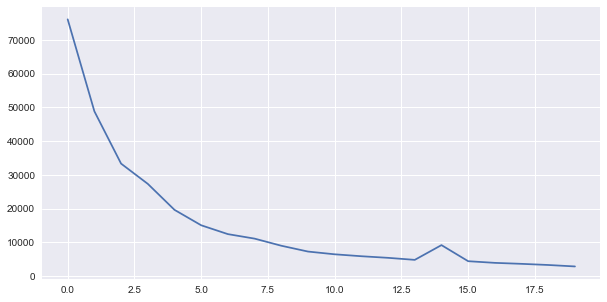

In [41]:
plt.figure(figsize=(10,5))
plt.plot(loss_by_run)
plt.show()

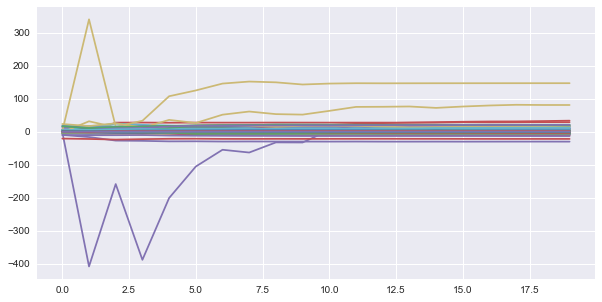

In [42]:
plt.figure(figsize=(10,5))
plt.plot(parameter_by_run)
plt.show()

In [43]:
X = train[features].values
y = train[target].values
X_test = test[features].values
# y_test = test[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

#get model parameters of last run by interation
kml.model.get_param_by_iter()
kml.model.get_loss_by_iter()

print('performance by run')
for i in range(parameter_by_run.shape[0]):
    w=parameter_by_run[i].copy()
    autoencoder_SSE_train = autoencoder_function(X,X,w,model_shapes)
    autoencoder_SSE_test = autoencoder_function(X_test,X_test,w,model_shapes)
    print('iteration',i,'train rsquared',1-autoencoder_SSE_train/autoencoder_SST_train,'test rsquared',1-autoencoder_SSE_test/autoencoder_SST_test)

performance by run
iteration 0 train rsquared 0.150194397636 test rsquared 0.147393967407
iteration 1 train rsquared 0.429166157218 test rsquared 0.427665596608
iteration 2 train rsquared 0.635475657519 test rsquared 0.634973096386
iteration 3 train rsquared 0.708687242438 test rsquared 0.708411877331
iteration 4 train rsquared 0.783977183682 test rsquared 0.7837629366
iteration 5 train rsquared 0.830015142301 test rsquared 0.829713127146
iteration 6 train rsquared 0.858136432656 test rsquared 0.857989033603
iteration 7 train rsquared 0.877759661645 test rsquared 0.877625649223
iteration 8 train rsquared 0.897650851565 test rsquared 0.897625044183
iteration 9 train rsquared 0.914282654105 test rsquared 0.9143493577
iteration 10 train rsquared 0.927670565024 test rsquared 0.927799461907
iteration 11 train rsquared 0.936352064563 test rsquared 0.936550898509
iteration 12 train rsquared 0.942844511683 test rsquared 0.943063010957
iteration 13 train rsquared 0.947848026839 test rsquared 0.

In [44]:
import gc
gc.collect()

96438

In [45]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

input_data = Input(shape=(X.shape[1],))
layer1 = Dense(10, activation='linear')(input_data)
layer2 = Dense(len(features), activation='linear')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='mean_squared_error')

start  = time.time()
model.fit(X, X,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test, X_test))
end = time.time()
print(end-start)

Using TensorFlow backend.


Train on 124999 samples, validate on 550000 samples
Epoch 1/100
124999/124999 [==============================] - 1s 9us/step - loss: 205783.2810 - val_loss: 112935.8621
Epoch 2/100
124999/124999 [==============================] - 1s 6us/step - loss: 80279.3796 - val_loss: 55666.1744
Epoch 3/100
124999/124999 [==============================] - 1s 6us/step - loss: 43911.0031 - val_loss: 34595.3390
Epoch 4/100
124999/124999 [==============================] - 1s 6us/step - loss: 29768.0672 - val_loss: 25807.4353
Epoch 5/100
124999/124999 [==============================] - 1s 6us/step - loss: 23558.4788 - val_loss: 21590.0758
Epoch 6/100
124999/124999 [==============================] - 1s 5us/step - loss: 20307.4255 - val_loss: 19092.5432
Epoch 7/100
124999/124999 [==============================] - 1s 5us/step - loss: 18201.5993 - val_loss: 17305.2442
Epoch 8/100
124999/124999 [==============================] - 1s 5us/step - loss: 16604.6962 - val_loss: 15873.4888
Epoch 9/100
124999/124999 